# Factors that Influence Outcomes of the Five Domains of Speech-Language in Children with Hearing Loss at age 4 years

Paper 1

In [2]:
# Import modules and set options
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(context='notebook', style='ticks')

Import data

In [3]:
lsl_dr = (pd.read_csv('../data/clean/lsl_dr.csv', index_col=0, low_memory=False)
                  .rename({'onset_1':'identify_mo'}, axis=1))

In [4]:
lsl_dr.head()

,redcap_event_name,academic_year_rv,hl,male,_race,prim_lang,sib,_mother_ed,father_ed,par1_ed,...,gf3_sis_ss,gf3_siw_ss,gf_version,ppvt_f,ppvt_ss,rowpvt_ss,school,score,test_name,test_type
0,initial_assessment_arm_1,2002.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,101,58.0,NaN,EOWPVT
1,initial_assessment_arm_1,2002.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,101,51.0,PLS,receptive
2,initial_assessment_arm_1,2002.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,101,60.0,PLS,expressive
3,initial_assessment_arm_1,2002.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,101,54.0,PLS,total
4,initial_assessment_arm_1,2013.0,0.0,1.0,0.0,0.0,1.0,4.0,5.0,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,626,89.0,NaN,Goldman


Indicator for non-profound hearing loss

In [5]:
lsl_dr['deg_hl_below6'] = lsl_dr.degree_hl<6
lsl_dr.loc[lsl_dr.degree_hl.isnull(), 'deg_hl_below6'] = np.nan

Indicator for first intervention outside OPTION

In [6]:
lsl_dr['int_outside_option'] = lsl_dr.age > lsl_dr.age_int
lsl_dr.loc[lsl_dr.age < lsl_dr.age_int, 'int_outside_option'] = np.nan

Indicator for high school graduation of mother

In [7]:
lsl_dr['mother_hs'] = lsl_dr.mother_ed > 1
lsl_dr.loc[lsl_dr.mother_ed.isnull(), 'mother_hs'] = None

Create age in years variable

In [8]:
lsl_dr['age_years'] = lsl_dr.age/12.

Create school index

In [9]:
schools_unique = np.sort(lsl_dr.school.unique())
school_lookup = dict(zip(schools_unique, range(len(schools_unique))))

In [10]:
lsl_dr['school_idx'] = lsl_dr.school.replace(school_lookup)

Create student index

In [11]:
student_unique = np.sort(lsl_dr.study_id.unique())
student_lookup = dict(zip(student_unique, range(len(student_unique))))

In [12]:
lsl_dr['student_idx'] = lsl_dr.study_id.replace(student_lookup)

### Exclusions

Drop non-english and other disabilities, filter for hearing loss

In [13]:
other_etiology = (lsl_dr[['etiology_3___2', 'etiology_3___4', 'etiology_3___5', 'etiology_3___6', 'etiology_3___9',
       'etiology_oth___1', 'etiology_oth___3', 'etiology_oth___4', 'etiology_oth___8', 'etiology_oth___9']]
                      .sum(1).astype(bool))

In [14]:
inclusion_mask = (~lsl_dr.non_english.astype(bool) 
                  & (lsl_dr.degree_hl!=0))

In [15]:
covariates = ['score', 'student_idx', 'school_idx', 'male', 'sib', 'family_inv', 'race', 
              'age_test', 'premature_weeks', 'age_amp', 'parent_hl',
              'domain', 'deg_hl_below6', 'mother_hs', 'mother_college', 'age_years', 'test_type', 
              'time', 'bilateral_ci', 'one_or_both_parent_hl',
              'bilateral_ha', 'unilateral_ci', 'unilateral_ha', 
              'bimodal', 'assymetrical', 'age_int', 'autism']

In [16]:
hl_type_cols = lsl_dr.columns[lsl_dr.columns.str.contains('lateral')].values.tolist()

In [17]:
covariates += list(set(hl_type_cols))
covariates = list(set(covariates))

In [18]:
analysis_subset = lsl_dr.loc[inclusion_mask, covariates].copy().dropna(subset=['time'])
analysis_subset.shape

(46786, 53)

In [19]:
analysis_subset[['bilateral_ci',
              'bilateral_ha', 'unilateral_ci', 'unilateral_ha', 'bimodal']].mean()

bilateral_ci     0.679755
bilateral_ha     0.191660
unilateral_ci    0.020327
unilateral_ha    0.025585
bimodal          0.058030
dtype: float64

In [20]:
analysis_subset['premature'] = (analysis_subset.premature_weeks>0).astype(float)
analysis_subset.loc[analysis_subset.premature_weeks.isnull(), 'premature'] = np.nan

Add expressive and receptive to langauge test domains

In [21]:
analysis_subset.loc[(analysis_subset.domain=='Language') & (analysis_subset.test_type=='receptive'), 
           'domain'] = 'Receptive Language'
analysis_subset.loc[(analysis_subset.domain=='Language') & (analysis_subset.test_type=='expressive'), 
           'domain'] = 'Expressive Language'

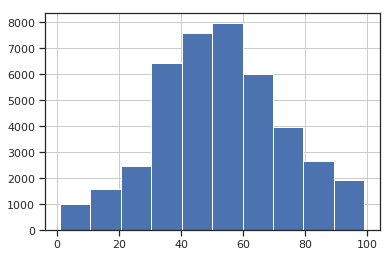

In [22]:
analysis_subset[analysis_subset.age_test<100].age_test.hist()

Drop records with missing race and age at ernollment, since there is less than 1% of them

In [23]:
analysis_subset = analysis_subset.dropna(subset=['race', 'age_years', 'age_test', 'parent_hl'])

In [24]:
assert not analysis_subset.autism.isnull().sum()

## Comparison of mean scores

Restrict to between 3 and 6 years

In [25]:
analysis_subset = analysis_subset[(analysis_subset.age_test>=36) & (analysis_subset.age_test<72)]

In [26]:
analysis_subset.shape

(24039, 54)

Take first test score

In [27]:
analysis_subset = analysis_subset.loc[analysis_subset.groupby("student_idx")["age_test"].idxmin()]

In [28]:
analysis_subset.shape

(2650, 54)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0a0bf93c18>,
      dtype=object)

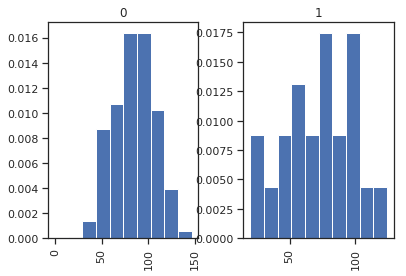

In [29]:
analysis_subset.hist(column='score', by='autism', density=True)

In [30]:
tests_autism = analysis_subset.query('autism==1').domain.value_counts()
tests_autism

Articulation             12
Expressive Vocabulary     6
Receptive Language        2
Receptive Vocabulary      2
Name: domain, dtype: int64

In [31]:
analysis_subset = analysis_subset[analysis_subset.domain.isin(['Articulation', 'Expressive Vocabulary'])]

In [32]:
from pymc3 import Bernoulli, Normal, Uniform, Dirichlet, Categorical, Beta, HalfCauchy
from pymc3 import Gamma, Exponential, Multinomial, HalfNormal, NormalMixture, Lognormal
from pymc3 import Model, Deterministic, sample
from arviz import plot_forest

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [33]:
autism, score = analysis_subset[['autism', 'score']].values.T
autism = autism.astype(int)

In [34]:
domain_lookup = {d:i for i,d in zip(range(6), analysis_subset.domain.unique())}

In [35]:
domain = analysis_subset.domain.replace(domain_lookup).values

In [36]:
with Model() as score_model:
    
    μ = Normal('μ', 100, sd=20, shape=4)
    σ = HalfNormal('σ', 10, shape=2)
    
    δ = Deterministic('difference', μ[2:] - μ[:2])
    
    y = Normal('y', μ[domain + autism*2], sd=σ[autism], observed=score)

In [37]:
with score_model:
    trace = sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:08<00:00, 705.24draws/s]


/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


[Text(0, 0, 'Articulation'), Text(0, 0, 'Expressive Vocabulary')]

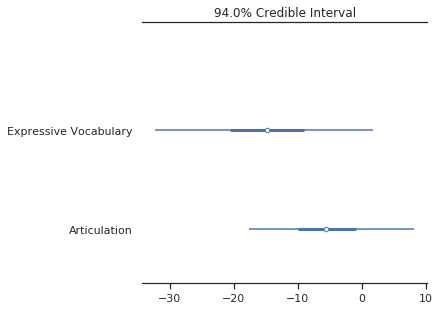

In [38]:
fig, (ax,) = plot_forest(trace, var_names=['difference'], combined=True)
ax.set_yticklabels(list(domain_lookup.keys())[::-1])

## Hearing Loss Within Autism Group

In [39]:
inclusion_mask = (~lsl_dr.non_english.astype(bool) &
                 (lsl_dr.autism==1))

In [40]:
all_autism = lsl_dr[inclusion_mask].copy()
all_autism.shape

(281, 252)

In [41]:
all_autism['hearing_loss'] = (all_autism.hl==0).astype(int)

In [43]:
hl, score = all_autism[['hearing_loss', 'score']].values.T
hl = hl.astype(int)

In [46]:
domain_lookup = {d:i for i,d in zip(range(6), all_autism.domain.unique())}
domain = all_autism.domain.replace(domain_lookup).values

In [53]:
n_domains = len(domain_lookup)

In [54]:
with Model() as hl_score_model:
    
    μ = Normal('μ', 100, sd=20, shape=n_domains*2)
    σ = HalfNormal('σ', 10, shape=2)
    
    δ = Deterministic('difference', μ[n_domains:] - μ[:n_domains])
    
    y = Normal('y', μ[domain + hl*2], sd=σ[hl], observed=score)

In [55]:
with hl_score_model:
    trace = sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:06<00:00, 883.19draws/s]


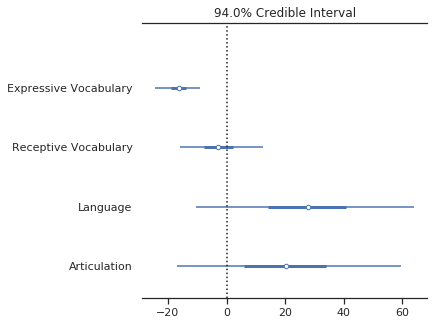

In [61]:
fig, (ax,) = plot_forest(trace, var_names=['difference'], combined=True)
ax.set_yticklabels(list(domain_lookup.keys())[::-1])
ax.vlines(0, *ax.get_ylim(), linestyles='dotted')

In [63]:
import arviz as az

In [67]:
tab = az.summary(trace, var_names=['difference'])
tab.index = list(domain_lookup.keys())

In [68]:
tab

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
Expressive Vocabulary,-16.41,4.07,0.07,-24.35,-9.15,2433.0,1.0
Receptive Vocabulary,-2.82,7.55,0.07,-15.73,12.45,2275.0,1.0
Language,27.27,20.04,0.12,-10.43,64.04,2359.0,1.0
Articulation,20.18,20.42,0.34,-17.05,59.39,2504.0,1.0
